Importing libaries and setting out and defining the algerbraic symbols used in the analytic part of the code.
This is effectivley a copy of the code for the S state but now with l=2 to avoid further complexities

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
import scipy

INITIAL_RANGE_PARAMETER = 0.001 # In [fm^-2]
V_0 = 40 # In [MeV, corresponds to the algerbraic symbol V0)
BETA = 0.2 # In [fm^-2], can be edited to get a better fit for a realistic density distrbution.
REDUCED_MASS = 846.8 # In [units], need to update value and units (10/11 A in MeV)
ORBITAL_QUANTUM_NUMBER = 2 # In units of hbar
HBAR = 1 # In natural units, also true for c but this does not appear in any algerbraic expresions
SUM_LIMIT = 30 # Determines the number of gaussians we expand our wave function to
XVALS = 300 # number of x values to plot in our plot of u(r)

r, μ, α, α1, α2, l, β, V0, hbar = sympy.symbols('r μ α α1 α2 l β V0 hbar', positive=True)

Where: r is the radius
       μ is the reduced mass
       β is the potential parameter
       V0 is the depth of the potential well
       α is the range parameter for the gaussian wavefunction
       l is the orbital angular momentum qunatum number (we take l=0 to start with)
       hbar is the reduced plancks constant

The gaussian wavefunction, gaussian potential, and kinetic energy operator are defined below 

In [113]:
def gaussian_wave_function(r, α, l=ORBITAL_QUANTUM_NUMBER):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : sympy variable
    α : sympy variable characterising the gaussian
    l: intger, the orbital angular momentum quantum number

    Returns
    -------
    float the value of the gaussian wavefunction at the radius r
    """
    if l == 0:
        return ((8 * α)/sympy.pi)**0.25 * sympy.exp(-1 * α * r**2)
    elif (2 * l)%2 == 0:
        return ((2**(2 * l + 1.5) * α**(l + 0.5)) / (sympy.functions.combinatorial.factorials.factorial2(
            2 * l - 1) * sympy.sqrt(sympy.pi)))**0.5 * r**(l) * sympy.exp(-1 * α * r**2)
    else:
        print("Invalid choice of l")
        return "????" # Need to change this to a end runtime


def gaussian_potential(r, V0, β):
    """
    Defines the spherically symmetric gaussian potential as a function of radius we use as a 'first guess'
    to make our integrals analytic. Given as V = V_0 * e**(-beta * radius**2)

    Parameters
    ----------
    radius : float
    parameters : 1d array containg the fixed parameters for our potential. In the order [V_0, beta] (see slides/supplimentary notes) 

    Returns
    -------
    float with the value of the potential at a radius r

    """
    return -1 * V0 * sympy.exp(-1 * β * r**2)


def kinetic_energy_operator(r, wavefunction_1, wavefunction_2, α1, α2, μ, l=ORBITAL_QUANTUM_NUMBER):
    """
    Defines the kinetic energy operator for our system: '-\frac{\hbar^2}{2\mu}\frac{d^2}{dr^2} + \frac{l(l+1\hbar^2}{2\mu r^2}'

    Parameters
    ----------
    r : float
    wavefunction : sympy expression describing the wavefunction being operated on
    α : float characterising the gaussian
    hbar: float, the reduced plancks constant
    μ : float, the reduced mass
    l: intger, the orbital angular momentum quantum number

    Returns
    -------
    sympy expression describing the kinetic energy term in the eigenvalue problem

    """
    if l == 0:
        return (197**2 / (2 * μ)) * sympy.integrate(sympy.diff(wavefunction_1(r, α1), r) * sympy.diff(wavefunction_2(r, α2), r), (r, 0, sympy.oo))
    else:
        return (197**2 / (2 * μ)) * sympy.integrate(sympy.diff(wavefunction_1(r, α1), r) * sympy.diff(wavefunction_2(r, α2), r), (r, 0, sympy.oo)
                                                ) + ((197**2 * l * (l + 1)) / (2 * μ)) * sympy.integrate(
            wavefunction_1(r, α1) * wavefunction_2(r, α2) * r**(-2), (r, 0, sympy.oo))

The matrix elements are defined as

In [114]:
def N_ij(r, wavefunction_1, wavefunction_2, α1, α2):
    """
    Finds an expression for the overlap term in the eigenvalue problem.
    Evaluates the expression  N_{ij} = \int_0^{\infty}\phi_i(r)\phi_j(r)dr

    Parameters
    ----------
    r : sympy algerba symbol?
    wavefunction_1 : an expression for the lefthand wavefunctions in the system
    wavefunction_2 : an expression for the righthand wavefunctions in the system
    range_parameter_1 : float, range parameter associated with the first wavefunction
    range_parameter_2 : float, range parameter associated with the second wavefunction

    Returns
    -------
    sympy expression describing the overlap term in the eigenvalue problem

    """
    return sympy.integrate(wavefunction_1(r, α1) * wavefunction_2(r, α2), (r, 0, sympy.oo))


def T_ij(r, wavefunction_1, wavefunction_2, α1, α2, μ):
    """
    Finds an expression for the kinetic energy term in the eigenvalue problem.
    Evaluates the expression  T_{ij} = \int_0^{\infty}\phi_i(r)(-\frac{\hbar^2}{2\mu}\frac{d^2}{dr^2} + \frac{l(l+1\hbar^2}{2\mu r^2})\phi_j(r)dr

    Parameters
    ----------
    radius : float
    wavefunction_1 : an expression for one of the two wavefunctions in the system
    wavefunction_2 : an expression for one of the two wavefunctions in the system
    range_parameter_1 : float, range parameter associated with the first wavefunction
    range_parameter_2 : float, range parameter associated with the second wavefunction

    Returns
    -------
    sympy expression describing the kinetic energy term in the eigenvalue problem

    """
    return kinetic_energy_operator(r, wavefunction_1, wavefunction_2, α1, α2, μ)


def gaussian_V_ij(r, wavefunction_1, wavefunction_2, α1, α2, potential_function, V0, β):
    """
    Finds an expression for the gaussian potential energy term in the eigenvalue problem.
    Evaluates the expression  V_{ij} = \int_0^{\infty}\phi_i(r)V(r)\phi_j(r)dr

    Parameters
    ----------
    radius : float
    wavefunction_1 : an expression for one of the two wavefunctions in the system
    wavefunction_2 : an expression for one of the two wavefunctions in the system
    range_parameter_1 : float, range parameter associated with the first wavefunction
    range_parameter_2 : float, range parameter associated with the second wavefunction
    potential_function : sympy expression detailing the form of the potential

    Returns
    -------
    sympy expression describing the potential energy term in the eigenvalue problem

    """
    return sympy.integrate(wavefunction_1(r, α1) * potential_function(r, V0, β) * wavefunction_2(r, α2), (r, 0, sympy.oo))

Using these we can now generate our matricies to be solved
want to change the kinetic energy operator into the by parts method (integrating the derivative of both), which will be done later.

In [116]:
print(N_ij(r, gaussian_wave_function, gaussian_wave_function, α1, α2))
print(T_ij(r, gaussian_wave_function, gaussian_wave_function, α1, α2, μ))
print(gaussian_V_ij(r, gaussian_wave_function, gaussian_wave_function, α1, α2, gaussian_potential, V0, β))

5.65685424949238*α2**1.25/(α1**1.25*(1 + α2/α1)**(5/2))
439073.7131371*α2**1.25/(α1**0.25*μ*(1 + α2/α1)**(3/2)) + 38809*(-22.6274169979695*α2**2.25/(α1**1.25*(1 + α2/α1)**(5/2)) + 56.5685424949238*α2**2.25/(α1**1.25*(1 + α2/α1)**(7/2)) + 15.084944665313*α2**1.25/(α1**0.25*(1 + α2/α1)**(3/2)) - 22.6274169979695*α2**1.25/(α1**0.25*(1 + α2/α1)**(5/2)))/(2*μ)
-5.65685424949238*V0*α1**1.25*α2**1.25/((α1 + α2)**(5/2)*(β/(α1 + α2) + 1)**(5/2))


In [119]:
def matrix_generation(beta, size=SUM_LIMIT, reduced_mass=REDUCED_MASS ,reduced_planks_constant=HBAR):
    h_matrix = np.zeros(shape=(size, size))
    n_matrix = np.zeros(shape=(size, size))
    i = 0 # these count the elements of the matricies created
    j = 0

    overlap_integral = N_ij(r, gaussian_wave_function, gaussian_wave_function, α1, α2)
    kinetic_energy_integral = T_ij(r, gaussian_wave_function, gaussian_wave_function, α1, α2, μ)
    potential_integral = gaussian_V_ij(r, gaussian_wave_function, gaussian_wave_function, α1, α2, gaussian_potential, V0, β)

    while i < size:
        i_range_parameter = next_range_parameter(i)
        while j < size:
            j_range_parameter = next_range_parameter(j)
            h_matrix[i, j] = kinetic_energy_integral.subs({α1:i_range_parameter, α2:j_range_parameter, μ:reduced_mass}
                                                         ) + potential_integral.subs({α1:i_range_parameter, α2:j_range_parameter,
                                                                                           V0:V_0, β:beta})
            h_matrix[j, i] = h_matrix[i, j]
            n_matrix[i, j] = overlap_integral.subs({α1:i_range_parameter, α2:j_range_parameter})
            n_matrix[j, i] = n_matrix[i, j]
            j += 1
        i += 1
        print('row', i, 'column', j, 'complete')
        j = i

    return h_matrix, n_matrix


def next_range_parameter(i, initial_range_parameter=INITIAL_RANGE_PARAMETER, geometric_progression_number=2):
    """
    Finds the next range parameter given the previous and initial range parameters.
    Currently using a simple geometric series to determine range parameters.
    Chose geometric basis parameters $\alpha_i = \alpha_1a^{i-1}$ with initial parameters $\alpha_1 = 0.01, a=2$

    Parameters
    ----------
    i : int detailing the iteration number

    Returns
    -------
    new_range_parameter: float

    """
    new_range_parameter = initial_range_parameter * geometric_progression_number**(i)
    return new_range_parameter

In [120]:
h_matrix, n_matrix = matrix_generation(BETA)
#print(h_matrix)
#print(n_matrix)

row 1 column 30 complete
row 2 column 30 complete
row 3 column 30 complete
row 4 column 30 complete
row 5 column 30 complete
row 6 column 30 complete
row 7 column 30 complete
row 8 column 30 complete
row 9 column 30 complete
row 10 column 30 complete
row 11 column 30 complete
row 12 column 30 complete
row 13 column 30 complete
row 14 column 30 complete
row 15 column 30 complete
row 16 column 30 complete
row 17 column 30 complete
row 18 column 30 complete
row 19 column 30 complete
row 20 column 30 complete
row 21 column 30 complete
row 22 column 30 complete
row 23 column 30 complete
row 24 column 30 complete
row 25 column 30 complete
row 26 column 30 complete
row 27 column 30 complete
row 28 column 30 complete
row 29 column 30 complete
row 30 column 30 complete


We save the matrices to csv files to save having to use the computation time to rerun them every time we restart the code.

In [121]:
np.savetxt('d_state_h_matrix.csv', h_matrix, delimiter=',')
np.savetxt('d_state_n_matrix.csv', n_matrix, delimiter=',')

With our matrices found we now calculate the eigenvalues and the groundstate eigenvector, corresponding to the lowest (hence groundstate) energy.

In [122]:
eigenvalues, eigenvectors = scipy.linalg.eigh(h_matrix, n_matrix)
ground_state_eigenvector = np.asmatrix(eigenvectors[:, 0])
print("The eigenvalues are", eigenvalues)
print("The groundstate eigenvector is", ground_state_eigenvector)

The eigenvalues are [1.47961040e-01 4.36503723e-01 1.01455062e+00 2.16064045e+00
 4.40743000e+00 8.63653249e+00 1.62798248e+01 3.12015410e+01
 6.25178375e+01 1.28723044e+02 2.67865976e+02 5.54505373e+02
 1.13524733e+03 2.30219181e+03 4.63962430e+03 9.31662511e+03
 1.86718727e+04 3.73831678e+04 7.48066953e+04 1.49656593e+05
 2.99368487e+05 5.98848504e+05 1.19805845e+06 2.39768537e+06
 4.80208160e+06 9.63783535e+06 1.94134378e+07 3.96576408e+07
 8.23132816e+07 2.18300354e+08]
The groundstate eigenvector is [[-2.15388067e+00  2.11128166e+00 -1.18779413e+00  6.04910238e-01
  -2.88882198e-01  1.36716301e-01 -6.40079883e-02  2.99422569e-02
  -1.40386380e-02  6.57844719e-03 -3.06296933e-03  1.42608159e-03
  -6.62838541e-04  3.08453681e-04 -1.43618434e-04  6.69455254e-05
  -3.12210113e-05  1.45679175e-05 -6.79857037e-06  3.17306962e-06
  -1.48070235e-06  6.90640933e-07 -3.21744756e-07  1.49471451e-07
  -6.89928343e-08  3.13770626e-08 -1.37910040e-08  5.59901343e-09
  -1.88194472e-09  3.8276166

We now check our normalisation for our eigenvector

In [123]:
normalisation_check = ground_state_eigenvector * n_matrix * np.transpose(ground_state_eigenvector)
print("normalisation = ", normalisation_check[0, 0])

normalisation =  0.9999999999999982


With our normalised groundstate eigenvector we have the coeffffficients of our expansion terms. With these we get our terms in the expasion of u(r) as a set of gaussians (solved numerically rather than as an sympy expression)

In [124]:
def reduced_radial_wavefunction(x, sum_limit=SUM_LIMIT, orbital_quantum_number=ORBITAL_QUANTUM_NUMBER, xvals = XVALS):
    """
    Defines a numerical method of finding the reduced radial wavefunction as a sum of our gaussians.
    """
    range_parameter_array = np.zeros(shape=(1, sum_limit))
    for i in range(sum_limit):
        range_parameter_array[0, i] = next_range_parameter(i)

    temp = np.zeros(shape=(1, xvals))
    for i in range(xvals):
        for j in range(sum_limit):
            temp[0, i] += ground_state_eigenvector[0, j] * gaussian_wave_function(r, α, l=ORBITAL_QUANTUM_NUMBER).subs({r:x[i], α:range_parameter_array[0, j],
                                                                                                 l:orbital_quantum_number})
        temp[0, i] = temp[0, i]**2
    return temp

We now want to plot our reduced radial wavefunction squared to get a feel for the validity of our expansion

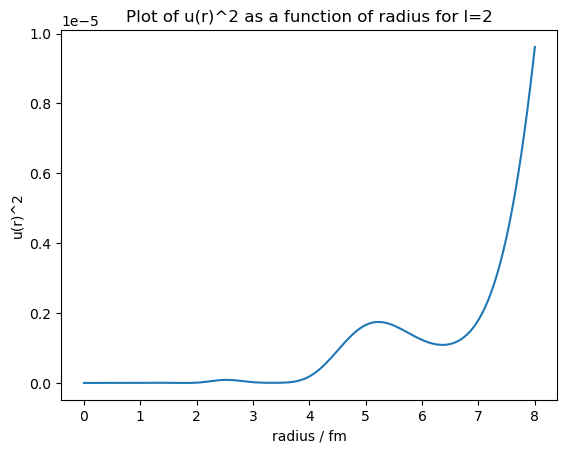

In [125]:
fig = plt.figure()
ax = fig.add_subplot()

x_values = np.linspace(0.000001, 8.000001, XVALS)
evaluated_ur_values = reduced_radial_wavefunction(x_values)[0]
text_to_annotate = (f'Ground state energy is {eigenvalues[0]}')
#print(reduced_radial_wavefunction(x_values))

ax.set_title('Plot of u(r)^2 as a function of radius for l=2')
ax.set_xlabel('radius / fm')
ax.set_ylabel('u(r)^2')
ax.plot(x_values, evaluated_ur_values)
#ax.annotate(text_to_annotate, xy=(0.16, 0.14), xycoords='figure fraction',
#                fontsize='16', bbox=dict(boxstyle="square,pad=.5", fc="white"))

plt.savefig('d_state_plot.png', dpi=300)
plt.show()

We now check that we have the correct normalisation for the radial wavefunction (integral from 0-->inf = 1), using scipy.integrate.simpson

In [126]:
u_r_square_integral = scipy.integrate.simpson(evaluated_ur_values, x=x_values)
print("The integral of u(r)**2 over all space is", u_r_square_integral)
print("The groundstate energy eigenvalue is", eigenvalues[0], "MeV")

The integral of u(r)**2 over all space is 8.542787572240348e-06
The groundstate energy eigenvalue is 0.14796103986174822 MeV
